### MEL VGG16 TRAINED WITH ADAM
In this document we will read in our feature npy files, construct, train and evaluate a model for audio classification:

Important Reads:
* https://arxiv.org/pdf/1807.09902.pdf (dataset paper)


In [1]:
import sys, os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import random
import math
import importlib
import h5py

sys.path.append(os.path.abspath(os.path.join('..', '')))
import helper

#from netplot import ModelPlot # this fucking library uses a weird version of numpy so we are not gonna use it
from tensorflow.keras.utils import plot_model
from datetime import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import backend as keras_backend
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import *#Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.regularizers import l2

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# set the random seed
tf.random.set_seed(42)
np.random.seed(42)

# are we resuming training?
resume = False

2.8.0
Num GPUs Available:  1


2022-03-22 12:11:13.057086: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 12:11:13.094447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 12:11:13.094693: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


### NMELS 87 FEATURE READ IN
In this section we will read in our kaggle 2018 datasets which have already been featured extracted and normalized

In [2]:
# data set root
dataset_root_dir = os.path.join("/home/charlesedwards/Documents", 'kaggle_2018_dataset')

# get the train and test data directories
train_dir = os.path.join(dataset_root_dir, 'train')
test_dir = os.path.join(dataset_root_dir, 'test')

# get the catalog.csv for train and test directories
train_catalog_csv = os.path.join(train_dir, 'catalog.csv')
test_catalog_csv = os.path.join(test_dir, 'catalog.csv')

# read the catalog.csv files
train_metadata = pd.read_csv(train_catalog_csv)
test_metadata = pd.read_csv(test_catalog_csv)
metadata = pd.concat([train_metadata, test_metadata])

# the cached feature extraction data root folder
data_npy_folder = os.path.join(dataset_root_dir, 'data')

# load in pre-processed MFCC train data
X = np.load( os.path.join(data_npy_folder, "X-mel87_audio_data.npy" ))
y = np.load( os.path.join(data_npy_folder, "y-normalized_audio_data.npy" ))

In [3]:
indexes = []
total = len(metadata)
indexes = list(range(0, total))

# Randomize indexes
random.shuffle(indexes)

# Divide the indexes into Train and Test
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

# Split the metadata
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]

# Split the features with the same indexes
X_test = np.take(X, test_split_idx, axis=0)
y_test = np.take(y, test_split_idx, axis=0)
X_train = np.take(X, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)

# Also split metadata
test_meta = metadata.iloc[test_split_idx]
train_meta = metadata.iloc[train_split_idx]

# Print status
print("Test split: {} \t\t Train split: {}".format(len(test_meta), len(train_meta)))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))

# output X_train and X_test shape
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

# output y_train and y_test shape
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X[0].shape

Test split: 2214 		 Train split: 8859
X test shape: (2214, 87, 87) 	 X train shape: (8859, 87, 87)
y test shape: (2214,) 		 y train shape: (8859,)
X_train shape: (8859, 87, 87), X_test shape: (2214, 87, 87)
y_train shape: (8859,), y_test shape: (2214,)


(87, 87)

### Visualize the label count distribution for train and test data

<BarContainer object of 41 artists>

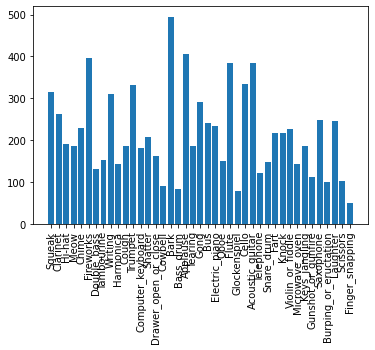

In [4]:
# visualize the label count distribution
labels = dict(zip(y_train,map(list(y_train).count, y_train)))
plt.xticks(rotation='vertical')
plt.bar(labels.keys(), labels.values())

<BarContainer object of 41 artists>

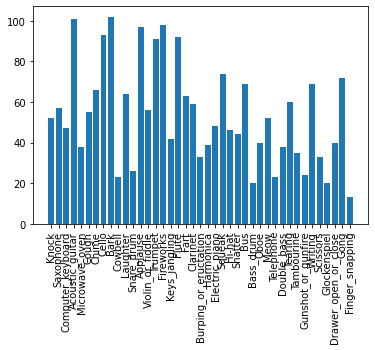

In [5]:
labels = dict(zip(y_test,map(list(y_test).count, y_test)))
plt.xticks(rotation='vertical')
plt.bar(labels.keys(), labels.values())

In [6]:
len(labels.keys())

41

### Encode Labels
In this section we will encode to categorical our y data

In [7]:
# encode the labels to categorical
le = LabelEncoder()

y_train_encoded = to_categorical(le.fit_transform(y_train))
y_test_encoded = to_categorical(le.fit_transform(y_test))

In [8]:
# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]

n_c = 0
#y_train[0], y_train_encoded[0], num_labels
y_train_encoded[n_c], le.classes_[n_c], num_labels

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'Acoustic_guitar',
 41)

### Reshape Data
In this section we will reshape our X data to be placed into the neural network

In [9]:

SAMPLE_RATE = 44100 #22050
DELTA_TIME = 1
BATCH_SIZE = 32
EPOCHS = 500 # standard we are training for 500 epochs

n_mels = 87
n_mfcc = 87

input_shape = (87, 87, 1)#(n_mfcc, 517, 1) # 1 + int(np.floor(audio_length/512))
input_shape

(87, 87, 1)

In [10]:
X_train = X_train.reshape(X_train.shape[0], *input_shape)
X_test = X_test.reshape(X_test.shape[0], *input_shape)

X_train.shape, X_test.shape

((8859, 87, 87, 1), (2214, 87, 87, 1))

### Construct the model
In this section we will construct the model

In [11]:
if resume is False: # if we are not resuming from a previous model

    model = tf.keras.applications.vgg16.VGG16(
        include_top=True, weights=None, input_tensor=None,
        input_shape=input_shape, pooling=None, classes=num_labels,
        classifier_activation='softmax'
    )

2022-03-22 12:11:16.571114: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-22 12:11:16.573176: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 12:11:16.573723: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 12:11:16.574135: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

### compile and visualise the model
Yes, batch size affects Adam optimizer. Common batch sizes 16, 32, and 64 can be used. Results show that there is a sweet spot for batch size, where a model performs best. For example, on MNIST data, three different batch sizes gave different accuracy as shown in the table below:
```
|Batch Size | Test Accuracy        |
-----------------------------------|
|1024       |  96% with 30 epochs  |
|64         |  98% with 30 epochs  |
|2          |  99% with 30 epochs  |
|__________________________________|
```
https://stats.stackexchange.com/questions/308424/how-does-batch-size-affect-adam-optimizer
<br>

### Categorical Crossentropy

**categorical_crossentropy:** Used as a loss function for multi-class classification model where there are two or more output labels. The output label is assigned one-hot category encoding value in form of 0s and 1. The output label, if present in integer form, is converted into categorical encoding using keras.

In [12]:
# 2. compile the model
if resume is False:
    
    #learning_rate=0.001#0.001
    #beta_1=0.9
    #beta_2=0.999

    # NOTE: values above was overfitting

    # INCREASE THE LEARNING RATE FROM 0.001 to 0.01
    learning_rate = 0.01 #0.001 #1e-4 #0.000001 # 5
    beta_1 = 0.9#0.99
    beta_2 = 0.999
    epsilon=1e-07 
    
    model.compile(
        loss = "categorical_crossentropy", # mean absolute error predicted vs observed
        # previous failure training used 1e-4, beta_1=0.99, beta_2=0.999, only achieved a val_loss did not improve from 0.04701
        optimizer = tf.keras.optimizers.SGD(lr=learning_rate),
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon), #tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon), # stochastic gradient descent (lr=1e-3)
        metrics=['accuracy'] # metrics accuracy
    )

### visualise the model

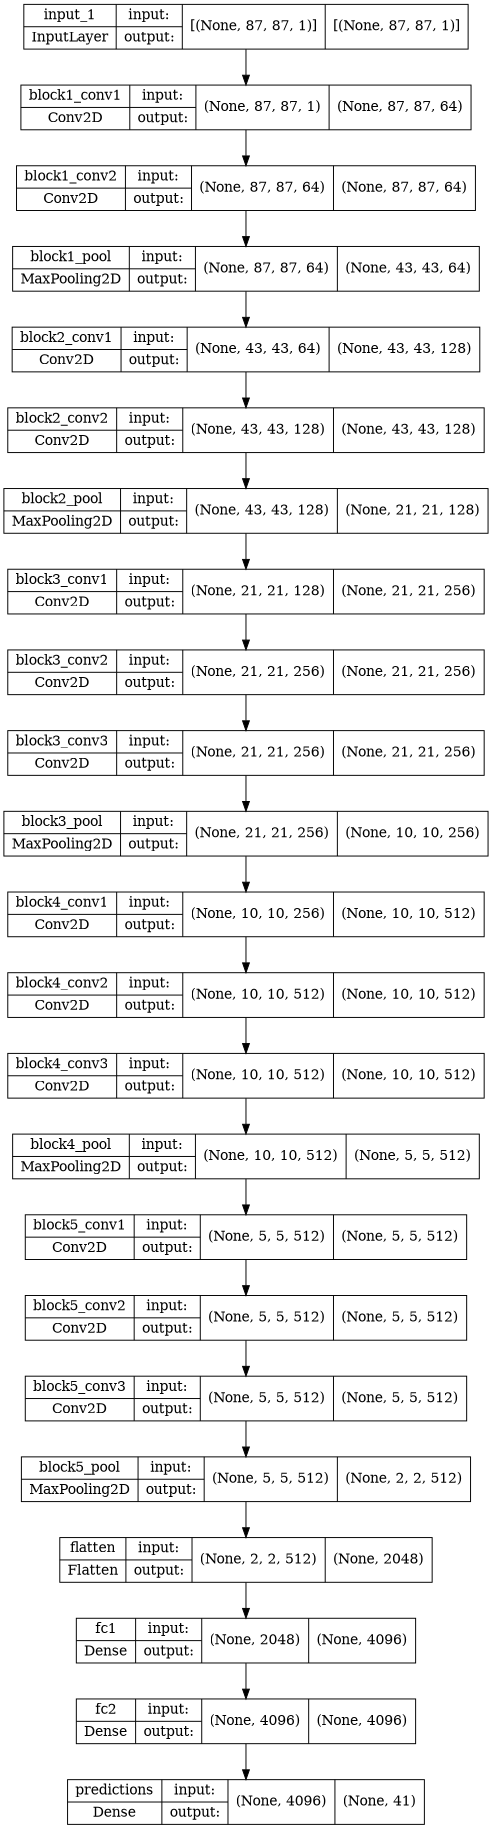

In [13]:

plot_model(model, show_shapes=True, expand_nested=True, dpi=70)

### train the model

In [14]:
# set the model path
model_dir = os.path.join( dataset_root_dir, 'models')

if resume is False:
    # this is where we will save the model too
    model_path = os.path.join(model_dir, f'{model.name.upper()}_ADAM_A2_lr-{learning_rate}_b1-{beta_1}_b2-{beta_2}_epsilon-{epsilon}_MAX_EPOCH-{EPOCHS}_BATCH-{BATCH_SIZE}.h5')
else:
    num_epochs = 500
    num_batch_size = 32 # recommend keeping same as saved model
    print("Resuming training...")
    model_path = os.path.join(model_dir, '')
    # Load best saved model
    print("Loading best saved model...")
    model = load_model(model_path)

model_path

'/home/charlesedwards/Documents/kaggle_2018_dataset/models/VGG16_ADAM_A2_lr-0.01_b1-0.9_b2-0.999_epsilon-1e-07_MAX_EPOCH-500_BATCH-32.h5'

In [15]:
# Save checkpoints
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path, 
    verbose=1, 
    save_best_only=True
)

# early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6#3
)

start = datetime.now()

# 3. train the model

history = model.fit(
    X_train, 
    y_train_encoded, 
    validation_data=(X_test, y_test_encoded),
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    #validation_split=0.2,#1/12.,
    callbacks=[checkpointer, early_stopping_callback], # early_stopping_callback 
    verbose=1
)

end = datetime.now() - start
print("Training time: {}".format(end))

Epoch 1/500


2022-03-22 12:11:19.982484: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302


277/277 [==============================] - ETA: 0s - loss: 530136.3750 - accuracy: 0.0512
Epoch 1: val_loss improved from inf to 3.63220, saving model to /home/charlesedwards/Documents/kaggle_2018_dataset/models/VGG16_ADAM_A2_lr-0.01_b1-0.9_b2-0.999_epsilon-1e-07_MAX_EPOCH-500_BATCH-32.h5
277/277 [==============================] - 30s 97ms/step - loss: 530136.3750 - accuracy: 0.0512 - val_loss: 3.6322 - val_accuracy: 0.0461
Epoch 2/500
277/277 [==============================] - ETA: 0s - loss: 3.6161 - accuracy: 0.0524
Epoch 2: val_loss improved from 3.63220 to 3.62344, saving model to /home/charlesedwards/Documents/kaggle_2018_dataset/models/VGG16_ADAM_A2_lr-0.01_b1-0.9_b2-0.999_epsilon-1e-07_MAX_EPOCH-500_BATCH-32.h5
277/277 [==============================] - 26s 94ms/step - loss: 3.6161 - accuracy: 0.0524 - val_loss: 3.6234 - val_accuracy: 0.0461
Epoch 3/500
277/277 [==============================] - ETA: 0s - loss: 3.6140 - accuracy: 0.0547
Epoch 3: val_loss did not improve from 3.

In [16]:
# separate the dictionaries loss and accuracy into their own dictionary
loss = history.history['loss']
val_loss = history.history['val_loss']

loss_dict = {'val_loss':val_loss, 'loss':loss}

# separate the dictionaries accuracy and val_accuracy into their own dictionary
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

accuracy_dict = {'val_accuracy':val_accuracy, 'accuracy':accuracy}


Text(0.5, 0, 'epochs')

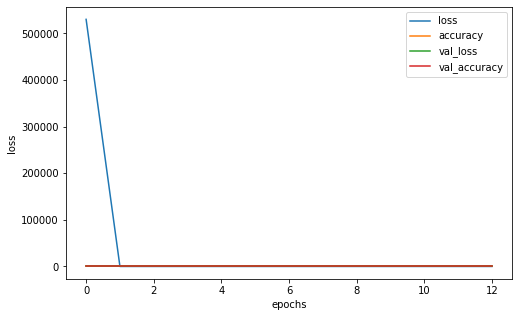

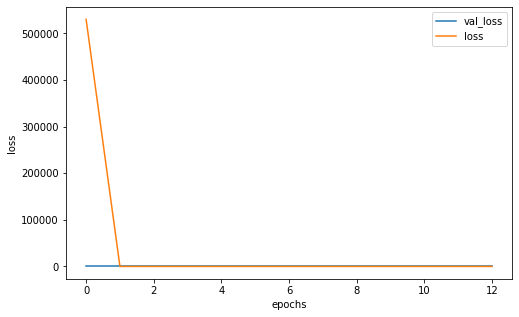

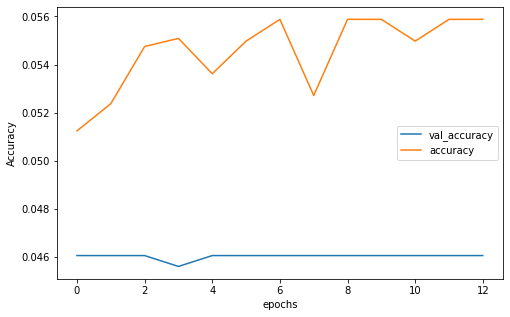

In [17]:
# plot history also known as loss curve 
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.ylabel("loss")
plt.xlabel("epochs")

pd.DataFrame(loss_dict).plot(figsize=(8, 5))
plt.ylabel("loss")
plt.xlabel("epochs")

pd.DataFrame(accuracy_dict).plot(figsize=(8, 5))
plt.ylabel("Accuracy")
plt.xlabel("epochs")

In [18]:

model.metrics_names

['loss', 'accuracy']

In [23]:

# set the model path
model_dir = os.path.join( dataset_root_dir, 'models')
#model_path = os.path.join(model_dir, "V3/RESNET")
model_path = os.path.join(model_dir, f'VGG16_ADAM_A2_lr-0.01_b1-0.9_b2-0.999_epsilon-1e-07_MAX_EPOCH-500_BATCH-32.h5')


model = load_model(model_path)

In [24]:
importlib.reload(helper)
helper.model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

70/70 [==============================] - 2s 28ms/step - loss: 3.6171 - accuracy: 0.0461
                    LOSS      ACCURACY
--------------------------------------
Training:         3.6070        5.5875
Test:             3.6171        4.6070
Normal diff          0.28 


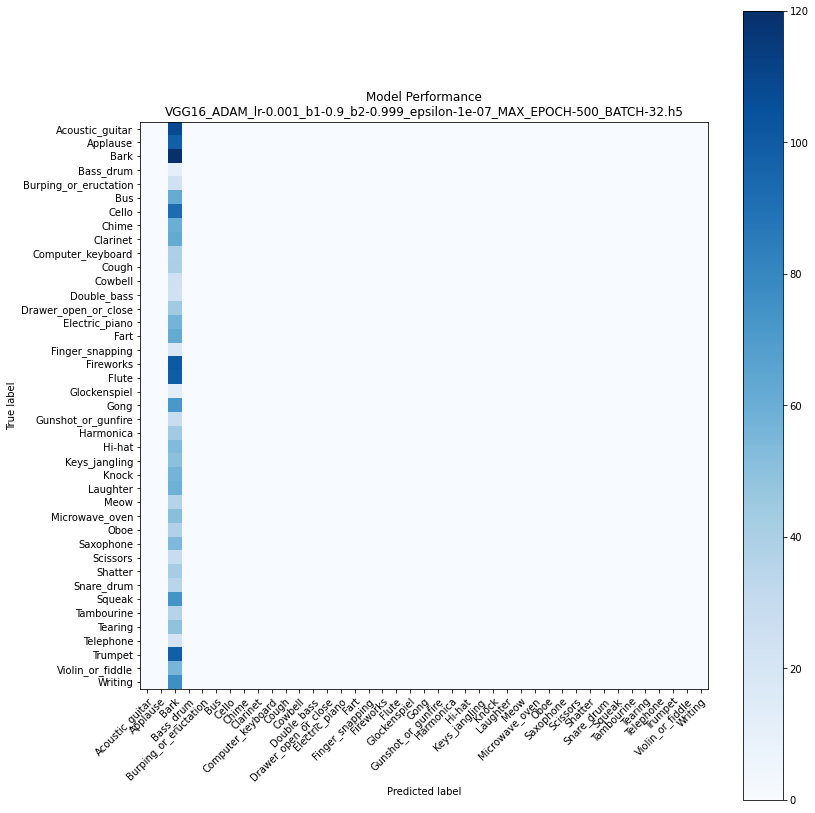

In [ ]:

importlib.reload(helper)

# Sets decimal precision (for printing output only)
np.set_printoptions(precision=2)

# Predict probabilities for test set
y_probs = model.predict(X_test, verbose=0)

# Get predicted labels
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test_encoded, axis=1)

# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)

helper.plot_confusion_matrix(
    cm=cm,
    classes=le.classes_.tolist(),
    normalized=False, 
    title=f"Model Performance\n{model_path.split('/')[-1]}", 
    cmap=plt.cm.Blues,
    size=(12,12))

### Custom H5PY format
This section will append the label information into the h5 model so that our interface program can easily load these models

In [ ]:
importlib.reload(helper)
model, metadata, dfe = helper.load_model_ext(model_path)
model, metadata, dfe

(<keras.engine.functional.Functional at 0x7fcb9b79b610>, None, None)

In [ ]:
import json
lables_properly = le.classes_.tolist()
labels_json = json.dumps(list(lables_properly))
labels_json

'["Acoustic_guitar", "Applause", "Bark", "Bass_drum", "Burping_or_eructation", "Bus", "Cello", "Chime", "Clarinet", "Computer_keyboard", "Cough", "Cowbell", "Double_bass", "Drawer_open_or_close", "Electric_piano", "Fart", "Finger_snapping", "Fireworks", "Flute", "Glockenspiel", "Gong", "Gunshot_or_gunfire", "Harmonica", "Hi-hat", "Keys_jangling", "Knock", "Laughter", "Meow", "Microwave_oven", "Oboe", "Saxophone", "Scissors", "Shatter", "Snare_drum", "Squeak", "Tambourine", "Tearing", "Telephone", "Trumpet", "Violin_or_fiddle", "Writing"]'

In [ ]:
helper.save_model_ext(model, model_path, overwrite=True, meta_data=labels_json, dfe="mel_87x87") # mfcc mel, mel_87x87, mfcc_87x87